In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [2]:
# Enable GPU memory growth to prevent overflow
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Define dataset path
DATA_DIR = "/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES"
IMG_SIZE = 224
BATCH_SIZE = 32

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values (0 to 1)
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # 20% for validation
)

val_datagen = ImageDataGenerator(
    rescale=1./255,  # No augmentation for validation
    validation_split=0.2
)


In [6]:
train_generator =train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)


Found 21726 images belonging to 10 classes.


In [7]:
print(train_generator.class_indices)

{'1. Eczema 1677': 0, '10. Warts Molluscum and other Viral Infections - 2103': 1, '2. Melanoma 15.75k': 2, '3. Atopic Dermatitis - 1.25k': 3, '4. Basal Cell Carcinoma (BCC) 3323': 4, '5. Melanocytic Nevi (NV) - 7970': 5, '6. Benign Keratosis-like Lesions (BKL) 2624': 6, '7. Psoriasis pictures Lichen Planus and related diseases - 2k': 7, '8. Seborrheic Keratoses and other Benign Tumors - 1.8k': 8, '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k': 9}


In [8]:

val_generator =val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 5427 images belonging to 10 classes.


In [9]:

# Enable memory growth for all GPUs
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


In [10]:
from tensorflow.keras.applications import EfficientNetB3
base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-30:]:  # Unfreeze last 30 layers
    layer.trainable = True



43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(train_generator.num_classes, activation='softmax')(x)

In [12]:
# Compile model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Callbacks
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss', mode='min', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint, early_stopping],
)



Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.5951 - loss: 1.1320
Epoch 1: val_loss improved from inf to 1.72779, saving model to best_model.keras
679/679 ━━━━━━━━━━━━━━━━━━━━ 720s 884ms/step - accuracy: 0.5953 - loss: 1.1316 - val_accuracy: 0.4133 - val_loss: 1.7278
Epoch 2/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.7911 - loss: 0.5616
Epoch 2: val_loss improved from 1.72779 to 1.39690, saving model to best_model.keras
679/679 ━━━━━━━━━━━━━━━━━━━━ 367s 535ms/step - accuracy: 0.7911 - loss: 0.5616 - val_accuracy: 0.5657 - val_loss: 1.3969
Epoch 3/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.8383 - loss: 0.4333
Epoch 3: val_loss did not improve from 1.39690
679/679 ━━━━━━━━━━━━━━━━━━━━ 369s 538ms/step - accuracy: 0.8383 - loss: 0.4333 - val_accuracy: 0.5806 - val_loss: 1.5990
Epoch 4/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.8749 - loss: 0.3487
Epoch 4: val_loss did not improve from 1.39690
679/679 ━━━━━━━━━━━━━━━━━━━━ 370s 54

In [15]:
# Save the model after training
model.save('skin_disease_detection_model.h5')


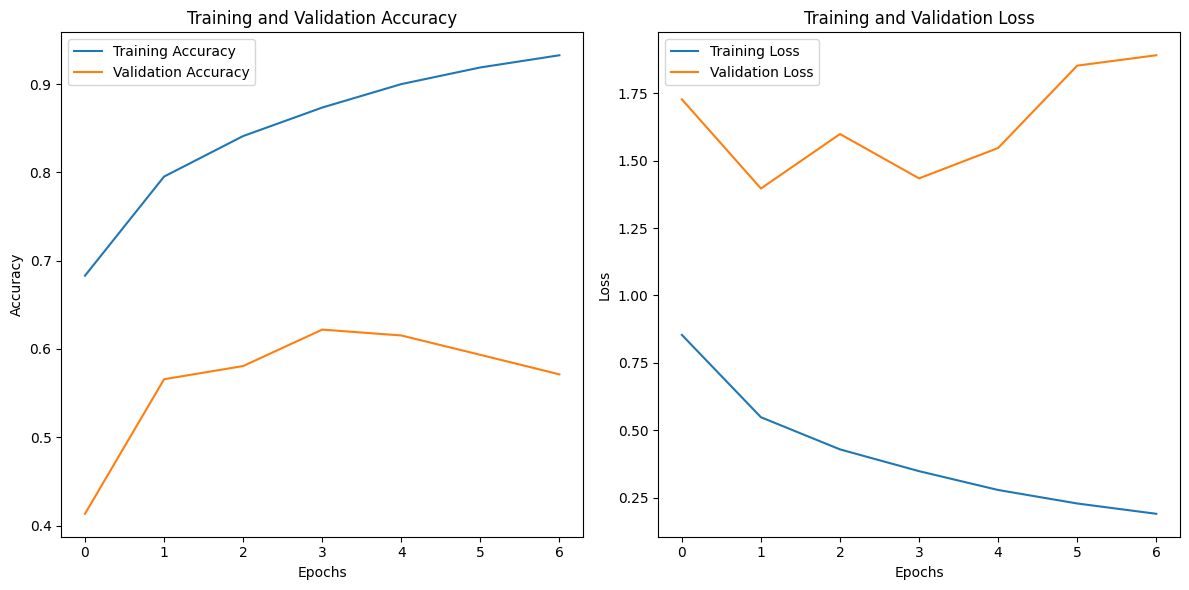

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()